In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

import mglearn
import spacy
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, recall_score, precision_recall_curve, roc_auc_score

In [2]:
fN = '/Users/anaso/Documents/AA/AA-22-23/Trabalho Final/imdbFull.p'

D = pickle.load(open(fN, 'rb'))

max_criticas = 2000
corpus = D.data[:max_criticas]
y = D.target[:max_criticas]

print("Tamanho corpus: {} documentos".format(len(corpus)))
print("Classes: {}".format(np.unique(y)))
print("Distribuição de criticas por classe: ", np.bincount(y))

Tamanho corpus: 2000 documentos
Classes: [ 1  2  3  4  7  8  9 10]
Distribuição de criticas por classe:  [  0 422 169 164 240   0   0 201 246 171 387]


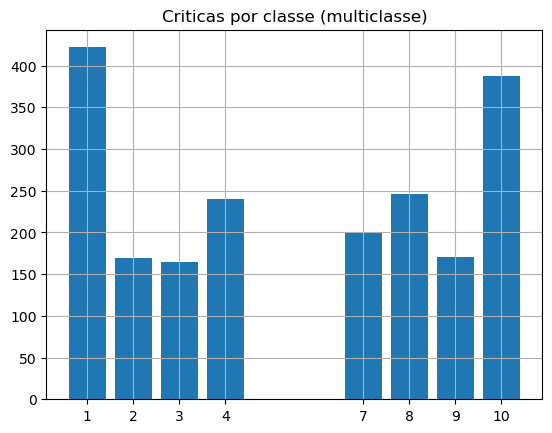

In [18]:
labels, counts = np.unique(y, return_counts=True)

plt.figure()
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Criticas por classe (multiclasse)")
plt.grid(True)

In [4]:
# Limpeza de dados
corpus = [critica.replace("<br />", " ") for critica in corpus]
corpus = [" ".join((palavra if palavra not in stop_words else " ") for palavra in critica.split()) for critica in corpus]
corpus = [" ".join(lemma.lemmatize(palavra) for palavra in critica.split()) for critica in corpus]

# Vetorização 
tf = TfidfVectorizer(min_df=3, max_df=0.9, ngram_range=(1,3)).fit(corpus)
corpus_p = tf.transform(corpus)


In [5]:
# Separação em treino e teste
corpus_trainval, corpus_test, y_trainval, y_test = train_test_split(corpus_p, y, test_size=1/3, shuffle=True, stratify=y)
corpus_train, corpus_validation, y_train, y_validation = train_test_split(corpus_trainval, y_trainval, test_size=1/2, shuffle=True, stratify=y_trainval)


print(corpus_train.shape, corpus_validation.shape, corpus_test.shape)

(666, 18084) (667, 18084) (667, 18084)


In [6]:
print("Treino", len(y_train))
print("Distribuição (Treino)", np.bincount(y_train))

print("\nValidação", len(y_validation))
print("Distribuição (Validação)", np.bincount(y_validation))

print("\nTeste", len(y_test))
print("Distribuição (Teste)", np.bincount(y_test))

Treino 666
Distribuição (Treino) [  0 140  56  55  80   0   0  67  82  57 129]

Validação 667
Distribuição (Validação) [  0 141  57  54  80   0   0  67  82  57 129]

Teste 667
Distribuição (Teste) [  0 141  56  55  80   0   0  67  82  57 129]


## Discriminante Logístico

<b style='color: red'>TODO: Mudar parametros da calibração</b>

In [7]:
pipe = make_pipeline(LogisticRegression(max_iter=10000))
param_grid = {'logisticregression__C': [0.1, 1, 10, 100], 
            'logisticregression__solver': ['liblinear'], 
            'logisticregression__multi_class': ['auto', 'ovr'], 
            'logisticregression__penalty': ['l1', 'l2']}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=3)
grid.fit(corpus_validation, y_validation)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.211 total time=   0.0s
[CV 2/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.212 total time=   0.0s
[CV 3/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.212 total time=   0.0s
[CV 1/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l2, logisticregression__solver=liblinear;, score=0.215 total time=   0.0s
[CV 2/3] END logisticregression__C=0.1, logisticregression__multi_class=auto, logisticregression__penalty=l2, logisticregression__solver=liblinear;, score=0.216 total time=   0.0s
[CV 3/3] END logisticregression__C=0.1,

In [8]:
#lr = LogisticRegression(C=10, penalty='l2', multi_class='auto', solver='liblinear')
lr = LogisticRegression(C=100, penalty='l2', multi_class='auto', solver='liblinear')
lr.fit(corpus_trainval, y_trainval)

#Treino
y_train_e = lr.predict(corpus_trainval)
#Teste
y_test_e = lr.predict(corpus_test)


<b style='color: red'> TODO: Alterar métricas de desempenho para as do classificados multiclasse </b>

In [9]:
lr_auc_train = roc_auc_score(y_trainval, lr.predict_proba(corpus_trainval)[:, 1])
print(lr_auc_train)

lr_auc_test = roc_auc_score(y_test, lr.predict_proba(corpus_test)[:, 1])
print(lr_auc_test)

lr_fpr_roc_train, lr_tpr_roc_train, lr_thresholds_roc_train = roc_curve(y_trainval, lr.predict_proba(corpus_trainval)[:, 1])
lr_fpr_roc_test, lr_tpr_roc_test, lr_thresholds_roc_test = roc_curve(y_test, lr.predict_proba(corpus_test)[:, 1])
plt.figure(figsize=(5,5))
plt.title("ROC Curve - Logistic Regression")
plt.plot(lr_fpr_roc_train, lr_tpr_roc_train, label="Train")
plt.plot(lr_fpr_roc_test, lr_tpr_roc_test, label="Test")
plt.xlabel("FPR (false alarm)")
plt.ylabel("TPR (recall)")
plt.legend()


lr_curve_precision_train, lr_curve_recall_train, lr_thresholds_train = precision_recall_curve(y_trainval, lr.predict_proba(corpus_trainval)[:, 1])
lr_curve_precision_test, lr_curve_recall_test, lr_thresholds_test = precision_recall_curve(y_test, lr.predict_proba(corpus_test)[:, 1])
plt.figure(figsize=(5,5))
plt.title("Precision Recall Curve - Logistic Regression")
plt.plot(lr_curve_precision_train, lr_curve_recall_train, label="Train")
plt.plot(lr_curve_precision_test, lr_curve_recall_test, label="Test")
plt.xlabel("PPV (precision)")
plt.ylabel("TPR (recall)")
plt.legend()



ValueError: multi_class must be in ('ovo', 'ovr')

### Resultados Treino

Amostras:  [  0 281 113 109 160   0   0 134 164 114 258]
Número de erros (treino): 0
Matriz de Confusão:


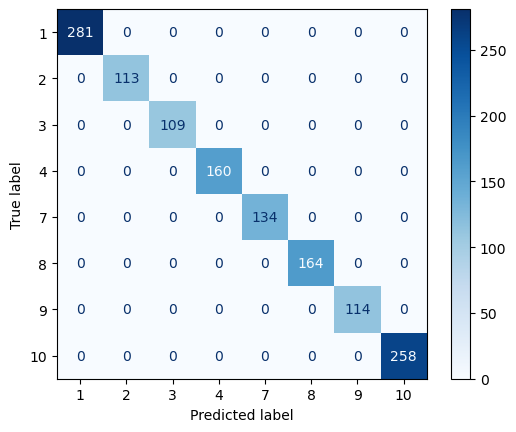

In [12]:
matriz_confusao = confusion_matrix(y_trainval, y_train_e)


print("Amostras: ", np.bincount(y_train_e))
print("Número de erros (treino): {}".format(np.sum(y_trainval != y_train_e)))
print("Matriz de Confusão:")
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=lr.classes_)
disp.plot(cmap='Blues')

### Resultados Teste

Amostras:  [  0 225  17  19  59   0   0  56  63  22 206]
Número de erros (treino): 407
Matriz de Confusão:


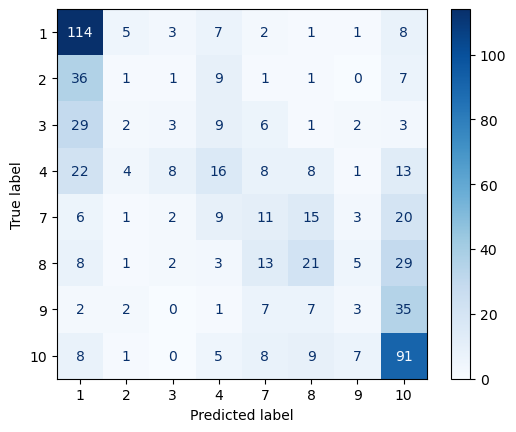

In [13]:
matriz_confusao = confusion_matrix(y_test, y_test_e)

print("Amostras: ", np.bincount(y_test_e))
print("Número de erros (treino): {}".format(np.sum(y_test != y_test_e)))
print("Matriz de Confusão:")
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=lr.classes_)
disp.plot(cmap='Blues')


## Support Vector Machine

<b style='color: red'>TODO: Mudar parametros da calibração</b>

In [14]:
pipe = make_pipeline(StandardScaler(with_mean=False), SVC(max_iter=10000))
param_grid = {'svc__C': [0.1, 1, 10, 100]}
# , 
#             'svc__decision_function_shape': ['ovr', 'ovo'],
#             'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#             'svc__gamma': [0.001, 0.01, 0.1, 1, 10], 
#             'svc__degree': [1, 2, 3]}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=3)
grid.fit(corpus_validation, y_validation)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n {}".format(grid.best_params_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ........................svc__C=0.1;, score=0.211 total time=   0.4s
[CV 2/3] END ........................svc__C=0.1;, score=0.212 total time=   0.3s
[CV 3/3] END ........................svc__C=0.1;, score=0.212 total time=   0.3s
[CV 1/3] END ..........................svc__C=1;, score=0.251 total time=   0.3s
[CV 2/3] END ..........................svc__C=1;, score=0.257 total time=   0.3s
[CV 3/3] END ..........................svc__C=1;, score=0.248 total time=   0.3s
[CV 1/3] END .........................svc__C=10;, score=0.305 total time=   0.3s
[CV 2/3] END .........................svc__C=10;, score=0.261 total time=   0.3s
[CV 3/3] END .........................svc__C=10;, score=0.225 total time=   0.3s
[CV 1/3] END ........................svc__C=100;, score=0.305 total time=   0.3s
[CV 2/3] END ........................svc__C=100;, score=0.261 total time=   0.3s
[CV 3/3] END ........................svc__C=100;,

In [15]:
svm = SVC(C=10) #, decision_function_shape='ovr', gamma=0.01, kernel='sigmoid')
svm.fit(corpus_trainval, y_trainval)

# Treino
y_train_e = svm.predict(corpus_trainval)
# Teste
y_test_e = svm.predict(corpus_test)

<b style='color: red'>TODO: Mudar medidas de desempenho para as do classificador multiclasse</b>

1.0
0.9424257254721327


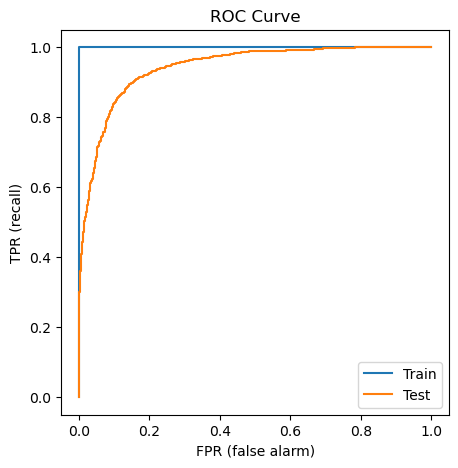

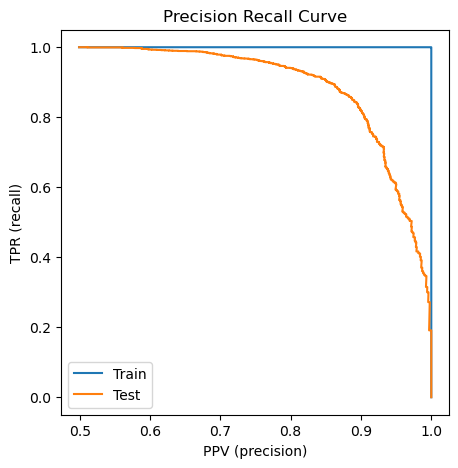

In [ ]:
svm_fpr_roc_train, svm_tpr_roc_train, svm_thresholds_roc_train = roc_curve(y_trainval, svm.decision_function(corpus_trainval))
svm_fpr_roc_test, svm_tpr_roc_test, svm_thresholds_roc_test = roc_curve(y_test, svm.decision_function(corpus_test))
plt.figure(figsize=(5,5))
plt.title("ROC Curve")
plt.plot(svm_fpr_roc_train, svm_tpr_roc_train, label="Train")
plt.plot(svm_fpr_roc_test, svm_tpr_roc_test, label="Test")
plt.xlabel("FPR (false alarm)")
plt.ylabel("TPR (recall)")
plt.legend()


svm_curve_precision_train, svm_curve_recall_train, svm_thresholds_roc_train = precision_recall_curve(y_trainval, svm.decision_function(corpus_trainval))
svm_curve_precision_test, svm_curve_recall_test, svm_thresholds_roc_test = precision_recall_curve(y_test, svm.decision_function(corpus_test))
plt.figure(figsize=(5,5))
plt.title("Precision Recall Curve")
plt.plot(svm_curve_precision_train, svm_curve_recall_train, label="Train")
plt.plot(svm_curve_precision_test, svm_curve_recall_test, label="Test")
plt.xlabel("PPV (precision)")
plt.ylabel("TPR (recall)")
plt.legend()

svm_auc_train = roc_auc_score(y_trainval, svm.decision_function(corpus_trainval))
svm_auc_test = roc_auc_score(y_test, svm.decision_function(corpus_test))

print(svm_auc_train)
print(svm_auc_test)

### Resultados Treino

Amostras:  [  0 281 113 109 160   0   0 134 164 114 258]
Número de erros (treino): 0
Matriz de Confusão:


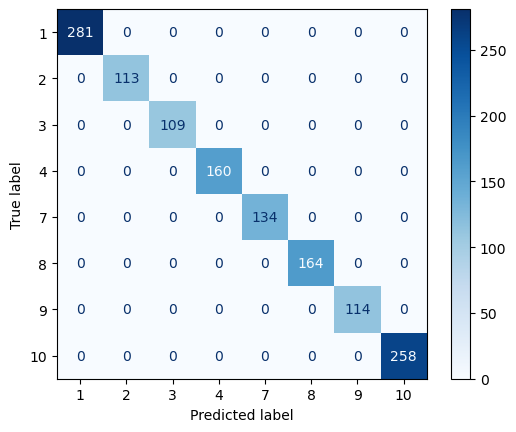

In [16]:
matriz_confusao = confusion_matrix(y_trainval, y_train_e)


print("Amostras: ", np.bincount(y_train_e))
print("Número de erros (treino): {}".format(np.sum(y_trainval != y_train_e)))
print("Matriz de Confusão:")
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=svm.classes_)
disp.plot(cmap='Blues')


### Resultados Teste

Amostras:  [  0 301   0   0  14   0   0   4  19   0 329]
Número de erros (treino): 415
Matriz de Confusão:


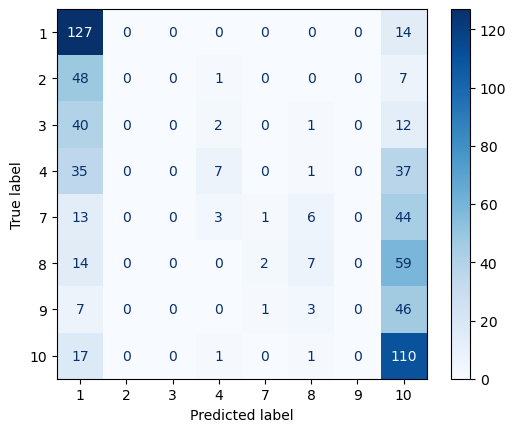

In [17]:
matriz_confusao = confusion_matrix(y_test, y_test_e)

print("Amostras: ", np.bincount(y_test_e))
print("Número de erros (treino): {}".format(np.sum(y_test != y_test_e)))
print("Matriz de Confusão:")
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=lr.classes_)
disp.plot(cmap='Blues')